# Setup

In [1]:
# Define Parameters
batch_size = 128
epochs = 100
task = 'Damage_Severity_Classification'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import torch
import torch.nn as nn
import torch.optim
import torchvision.models as models
import torchvision.transforms as transforms
import warnings
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

device = torch.device("cuda:0")
warnings.filterwarnings("ignore")

# Data Loading

In [3]:
# Damage Severity
train_path = '/work/u9562361/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_train_final.tsv'
test_path = '/work/u9562361/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_test_final.tsv'
dev_path = '/work/u9562361/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_dev_final.tsv'

train_label = pd.read_table(train_path)
test_label = pd.read_table(test_path)
dev_label = pd.read_table(dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(28319, 4)
(3865, 4)
(2712, 4)


In [4]:
class_label_map = {"severe": 2, "mild": 1, "little_or_none": 0}

def get_data(pd_label, class_label_map):
    image_path = pd_label['image_path']
    class_label = pd_label['class_label']

    X, y, valid_indices = [], [], []

    tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    for i in tqdm(range(len(image_path))):
        path = os.path.join('/work/u9562361/crisis_vision_benchmarks/', image_path[i])
        try:
            img = Image.open(path)
            if img is None:
                print(f"Error reading image: {path}")
                continue
            img = img.resize((224, 224))
            img = img.convert("RGB")
            img = np.array(img, dtype=np.float32) / 255.0
            img = tfms(img) 
            X.append(img)
            valid_indices.append(i)
        except Exception as e:
            print(f"Error opening image: {path} - {str(e)}")
            continue

    print(X[0].shape)
    X = np.stack(X)
    print(X.shape)

    for idx in tqdm(valid_indices):
        label = class_label[idx]
        if label not in class_label_map:
            print(f"Error: Unknown class label: {label}")
            continue
        y.append(class_label_map[label])

    y = np.array(y, dtype=np.int64)
    print(y.shape)

    return X, y

In [5]:
X_train, y_train = get_data(train_label, class_label_map)
X_test, y_test = get_data(test_label, class_label_map)
X_dev, y_dev = get_data(dev_label, class_label_map)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.int64)

trainset = TensorDataset(X_train, y_train)
testset = TensorDataset(X_test, y_test)
devset = TensorDataset(X_dev, y_dev)

 95%|█████████▍| 26887/28319 [13:31<00:49, 28.93it/s]

Error opening image: /work/u9562361/crisis_vision_benchmarks/data/multimodal-deep-learning-disaster-response-mouzannar/multimodal/damaged_infrastructure/images/wreckedcar_2017-02-23_21-15-25.jpg - image file is truncated (0 bytes not processed)


100%|██████████| 28319/28319 [14:08<00:00, 33.36it/s]


torch.Size([3, 224, 224])
(28318, 3, 224, 224)


100%|██████████| 28318/28318 [00:00<00:00, 430305.81it/s]


(28318,)


100%|██████████| 3865/3865 [02:07<00:00, 30.21it/s]


torch.Size([3, 224, 224])
(3865, 3, 224, 224)


100%|██████████| 3865/3865 [00:00<00:00, 306567.54it/s]


(3865,)


100%|██████████| 2712/2712 [01:32<00:00, 29.25it/s]


torch.Size([3, 224, 224])
(2712, 3, 224, 224)


100%|██████████| 2712/2712 [00:00<00:00, 471168.60it/s]

(2712,)


In [6]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
devloader = DataLoader(devset, batch_size=batch_size, shuffle=True, num_workers=4)

# ResNet50_pretrained

In [7]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [8]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [9]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet50_pretrained_v2.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [10]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.8139 - accuracy: 67.62% - val_loss: 0.7550 - val_accuracy: 69.42% - time: 95.20s
Epoch 2/100 - loss: 0.5754 - accuracy: 76.50% - val_loss: 0.6503 - val_accuracy: 71.93% - time: 94.85s
Epoch 3/100 - loss: 0.4793 - accuracy: 80.22% - val_loss: 0.6132 - val_accuracy: 73.71% - time: 94.88s
Epoch 4/100 - loss: 0.4089 - accuracy: 82.91% - val_loss: 0.6110 - val_accuracy: 74.83% - time: 94.61s
Epoch 5/100 - loss: 0.3430 - accuracy: 85.61% - val_loss: 0.6210 - val_accuracy: 75.32% - time: 94.96s
Epoch 6/100 - loss: 0.2845 - accuracy: 88.47% - val_loss: 0.6460 - val_accuracy: 75.34% - time: 95.03s
Epoch 7/100 - loss: 0.2321 - accuracy: 91.02% - val_loss: 0.6896 - val_accuracy: 74.93% - time: 94.87s
Epoch 8/100 - loss: 0.1844 - accuracy: 93.29% - val_loss: 0.7303 - val_accuracy: 74.70% - time: 94.92s
Epoch 9/100 - loss: 0.1490 - accuracy: 94.74% - val_loss: 0.7751 - val_accuracy: 74.41% - time: 94.96s
Epoch 10/100 - loss: 0.1209 - accuracy: 95.95% - val_loss: 0.8272 - val_a

Epoch 80/100 - loss: 0.0315 - accuracy: 98.81% - val_loss: 1.0888 - val_accuracy: 73.30% - time: 94.94s
Epoch 81/100 - loss: 0.0308 - accuracy: 98.79% - val_loss: 1.0831 - val_accuracy: 73.22% - time: 94.89s
Epoch 82/100 - loss: 0.0309 - accuracy: 98.78% - val_loss: 1.0809 - val_accuracy: 73.48% - time: 94.97s
Epoch 83/100 - loss: 0.0320 - accuracy: 98.69% - val_loss: 1.0859 - val_accuracy: 73.25% - time: 94.95s
Epoch 84/100 - loss: 0.0304 - accuracy: 98.78% - val_loss: 1.0699 - val_accuracy: 73.69% - time: 95.07s
Epoch 85/100 - loss: 0.0320 - accuracy: 98.79% - val_loss: 1.0852 - val_accuracy: 73.48% - time: 95.10s
Epoch 86/100 - loss: 0.0305 - accuracy: 98.82% - val_loss: 1.0787 - val_accuracy: 73.56% - time: 94.94s
Epoch 87/100 - loss: 0.0317 - accuracy: 98.75% - val_loss: 1.0856 - val_accuracy: 73.48% - time: 94.80s
Epoch 88/100 - loss: 0.0309 - accuracy: 98.77% - val_loss: 1.0903 - val_accuracy: 73.48% - time: 95.02s
Epoch 89/100 - loss: 0.0310 - accuracy: 98.79% - val_loss: 1.079

In [11]:
print(task + '_ResNet50_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet50_pretrained Classification Report:')
print(cr)

Damage_Severity_Classification_ResNet50_pretrained Performance:
Accuracy : 75.98%
F1-Score : 74.11%
Damage_Severity_Classification_ResNet50_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      2135
           1       0.42      0.40      0.41       629
           2       0.72      0.68      0.70      1101

    accuracy                           0.74      3865
   macro avg       0.66      0.65      0.65      3865
weighted avg       0.73      0.74      0.73      3865



## Visualize Results & Confusion Matrix

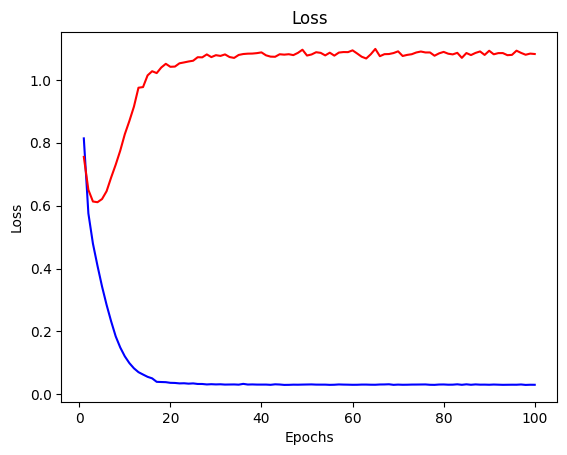

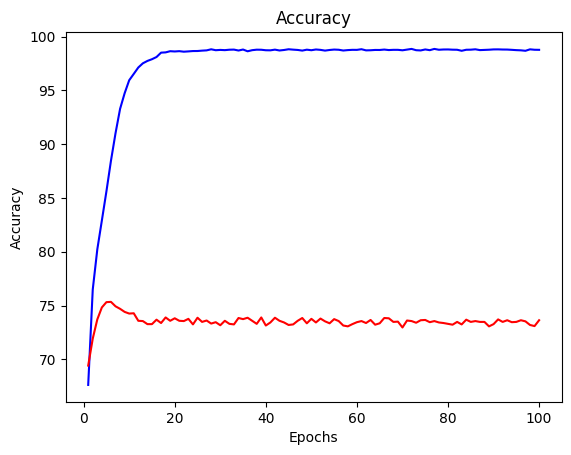

In [12]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Damage_Severity_Classification_ResNet50_pretrained Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


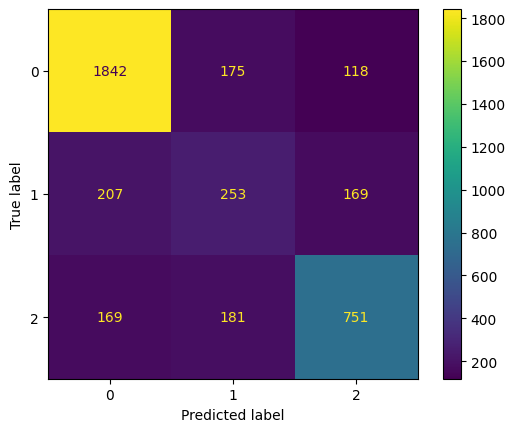

In [13]:
# "severe": 2, "mild": 1, "little_or_none": 0
print(task + '_ResNet50_pretrained Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# EfficientNetb1_pretrained

In [7]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [8]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [9]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_EfficientNetb1_pretrained_v2.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [10]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.9492 - accuracy: 64.20% - val_loss: 0.8678 - val_accuracy: 67.76% - time: 83.29s
Epoch 2/100 - loss: 0.7041 - accuracy: 73.40% - val_loss: 0.7226 - val_accuracy: 70.17% - time: 82.87s
Epoch 3/100 - loss: 0.6231 - accuracy: 75.11% - val_loss: 0.6689 - val_accuracy: 71.98% - time: 83.30s
Epoch 4/100 - loss: 0.5830 - accuracy: 76.51% - val_loss: 0.6419 - val_accuracy: 72.63% - time: 83.17s
Epoch 5/100 - loss: 0.5564 - accuracy: 77.76% - val_loss: 0.6208 - val_accuracy: 73.51% - time: 83.00s
Epoch 6/100 - loss: 0.5336 - accuracy: 78.60% - val_loss: 0.6064 - val_accuracy: 74.54% - time: 83.11s
Epoch 7/100 - loss: 0.5177 - accuracy: 79.12% - val_loss: 0.5936 - val_accuracy: 75.11% - time: 83.17s
Epoch 8/100 - loss: 0.5056 - accuracy: 80.00% - val_loss: 0.5854 - val_accuracy: 75.50% - time: 83.15s
Epoch 9/100 - loss: 0.4930 - accuracy: 80.28% - val_loss: 0.5855 - val_accuracy: 75.63% - time: 82.97s
Epoch 10/100 - loss: 0.4809 - accuracy: 80.67% - val_loss: 0.5733 - val_a

Epoch 80/100 - loss: 0.3244 - accuracy: 86.95% - val_loss: 0.5869 - val_accuracy: 76.25% - time: 82.90s
Epoch 81/100 - loss: 0.3274 - accuracy: 86.97% - val_loss: 0.5931 - val_accuracy: 76.66% - time: 82.79s
Epoch 82/100 - loss: 0.3273 - accuracy: 86.94% - val_loss: 0.5874 - val_accuracy: 76.61% - time: 82.78s
Epoch 83/100 - loss: 0.3257 - accuracy: 87.02% - val_loss: 0.5880 - val_accuracy: 76.61% - time: 82.73s
Epoch 84/100 - loss: 0.3247 - accuracy: 87.11% - val_loss: 0.5921 - val_accuracy: 76.40% - time: 82.74s
Epoch 85/100 - loss: 0.3246 - accuracy: 87.06% - val_loss: 0.5930 - val_accuracy: 76.48% - time: 82.91s
Epoch 86/100 - loss: 0.3258 - accuracy: 86.92% - val_loss: 0.5891 - val_accuracy: 76.46% - time: 82.75s
Epoch 87/100 - loss: 0.3257 - accuracy: 86.92% - val_loss: 0.5894 - val_accuracy: 76.51% - time: 82.91s
Epoch 88/100 - loss: 0.3282 - accuracy: 86.70% - val_loss: 0.5845 - val_accuracy: 76.69% - time: 82.77s
Epoch 89/100 - loss: 0.3264 - accuracy: 86.97% - val_loss: 0.589

In [11]:
print(task + '_EfficientNetb1_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_EfficientNetb1_pretrained Classification Report:')
print(cr)

Damage_Severity_Classification_EfficientNetb1_pretrained Performance:
Accuracy : 77.67%
F1-Score : 76.28%
Damage_Severity_Classification_EfficientNetb1_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2135
           1       0.48      0.35      0.41       629
           2       0.75      0.76      0.75      1101

    accuracy                           0.76      3865
   macro avg       0.69      0.67      0.67      3865
weighted avg       0.75      0.76      0.75      3865



## Visualize Results & Confusion Matrix

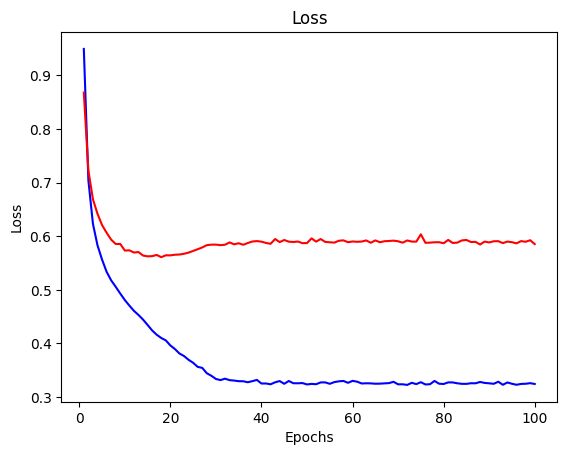

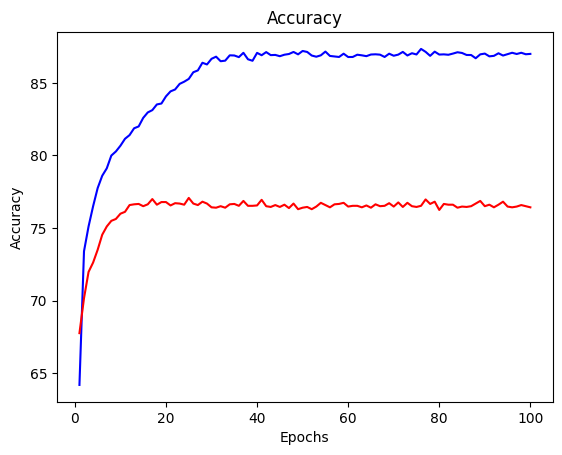

In [12]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Damage_Severity_Classification_EfficientNetb1_pretrained Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


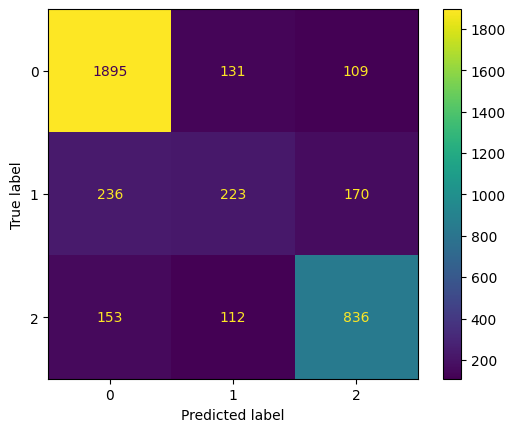

In [13]:
# "severe": 2, "mild": 1, "little_or_none": 0
print(task + '_EfficientNetb1_pretrained Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# VGG16_pretrained

In [7]:
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/u9562361/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

## Train

In [8]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [9]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_VGG16_pretrained_v2.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [10]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.6537 - accuracy: 73.30% - val_loss: 0.6287 - val_accuracy: 73.07% - time: 139.16s
Epoch 2/100 - loss: 0.5136 - accuracy: 79.24% - val_loss: 0.5970 - val_accuracy: 74.72% - time: 138.95s
Epoch 3/100 - loss: 0.4550 - accuracy: 81.69% - val_loss: 0.5827 - val_accuracy: 75.55% - time: 138.94s
Epoch 4/100 - loss: 0.4036 - accuracy: 84.04% - val_loss: 0.5833 - val_accuracy: 75.83% - time: 138.75s
Epoch 5/100 - loss: 0.3536 - accuracy: 86.04% - val_loss: 0.6058 - val_accuracy: 75.76% - time: 138.67s
Epoch 6/100 - loss: 0.3060 - accuracy: 88.11% - val_loss: 0.6184 - val_accuracy: 76.12% - time: 138.70s
Epoch 7/100 - loss: 0.2572 - accuracy: 90.11% - val_loss: 0.6652 - val_accuracy: 75.47% - time: 138.73s
Epoch 8/100 - loss: 0.2159 - accuracy: 91.86% - val_loss: 0.7112 - val_accuracy: 76.09% - time: 138.97s
Epoch 9/100 - loss: 0.1809 - accuracy: 93.20% - val_loss: 0.7742 - val_accuracy: 75.60% - time: 138.78s
Epoch 10/100 - loss: 0.1570 - accuracy: 94.30% - val_loss: 0.789

Epoch 80/100 - loss: 0.0615 - accuracy: 97.45% - val_loss: 1.2193 - val_accuracy: 75.55% - time: 139.26s
Epoch 81/100 - loss: 0.0592 - accuracy: 97.44% - val_loss: 1.2194 - val_accuracy: 75.58% - time: 139.37s
Epoch 82/100 - loss: 0.0606 - accuracy: 97.41% - val_loss: 1.2195 - val_accuracy: 75.55% - time: 139.52s
Epoch 83/100 - loss: 0.0609 - accuracy: 97.48% - val_loss: 1.2199 - val_accuracy: 75.58% - time: 139.43s
Epoch 84/100 - loss: 0.0609 - accuracy: 97.44% - val_loss: 1.2200 - val_accuracy: 75.58% - time: 139.19s
Epoch 85/100 - loss: 0.0586 - accuracy: 97.53% - val_loss: 1.2202 - val_accuracy: 75.58% - time: 139.16s
Epoch 86/100 - loss: 0.0606 - accuracy: 97.50% - val_loss: 1.2203 - val_accuracy: 75.58% - time: 139.42s
Epoch 87/100 - loss: 0.0622 - accuracy: 97.46% - val_loss: 1.2200 - val_accuracy: 75.55% - time: 138.39s
Epoch 88/100 - loss: 0.0619 - accuracy: 97.39% - val_loss: 1.2198 - val_accuracy: 75.55% - time: 138.58s
Epoch 89/100 - loss: 0.0593 - accuracy: 97.56% - val_lo

In [11]:
print(task + '_VGG16_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_VGG16_pretrained Classification Report:')
print(cr)

Damage_Severity_Classification_VGG16_pretrained Performance:
Accuracy : 76.64%
F1-Score : 75.72%
Damage_Severity_Classification_VGG16_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      2135
           1       0.46      0.37      0.41       629
           2       0.72      0.76      0.74      1101

    accuracy                           0.76      3865
   macro avg       0.68      0.66      0.67      3865
weighted avg       0.74      0.76      0.75      3865



## Visualize Results & Confusion Matrix

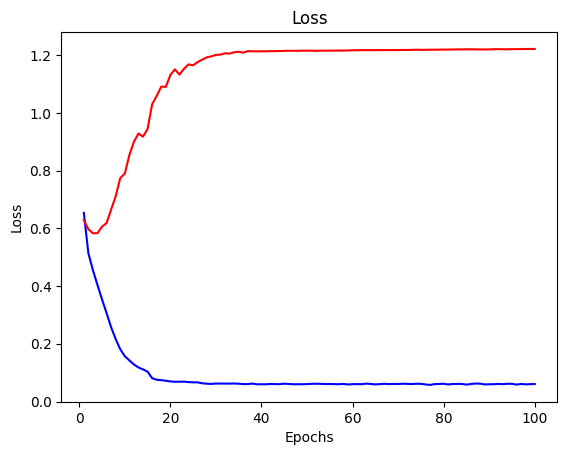

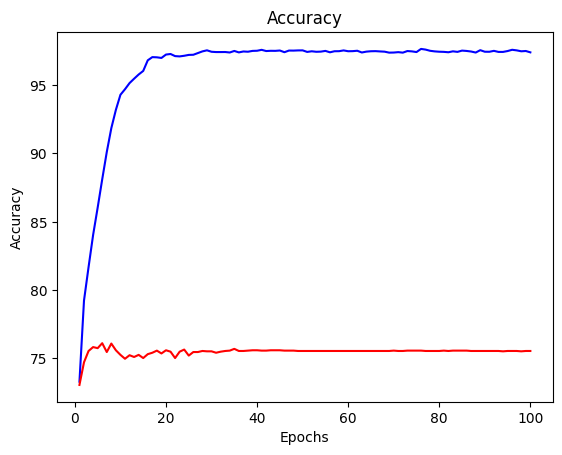

In [12]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Damage_Severity_Classification_VGG16_pretrained Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


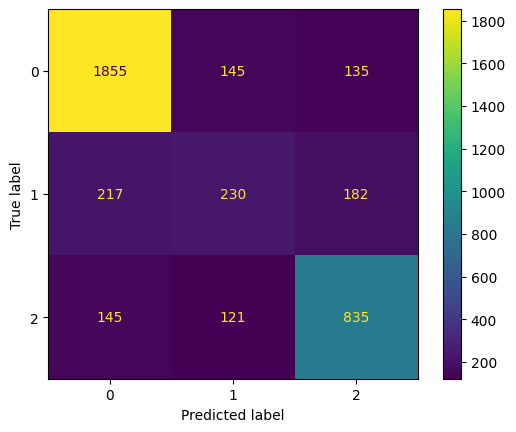

In [13]:
# "severe": 2, "mild": 1, "little_or_none": 0
print(task + '_VGG16_pretrained Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet18_pretrained

In [7]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/u9562361/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Train

In [8]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [9]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet18_pretrained_v2.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [10]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.7261 - accuracy: 68.71% - val_loss: 0.6698 - val_accuracy: 71.33% - time: 41.07s
Epoch 2/100 - loss: 0.5206 - accuracy: 79.53% - val_loss: 0.6364 - val_accuracy: 72.73% - time: 40.77s
Epoch 3/100 - loss: 0.4558 - accuracy: 82.16% - val_loss: 0.6264 - val_accuracy: 73.84% - time: 40.91s
Epoch 4/100 - loss: 0.4049 - accuracy: 84.44% - val_loss: 0.6286 - val_accuracy: 74.05% - time: 40.86s
Epoch 5/100 - loss: 0.3554 - accuracy: 86.40% - val_loss: 0.6330 - val_accuracy: 74.10% - time: 40.89s
Epoch 6/100 - loss: 0.3073 - accuracy: 88.51% - val_loss: 0.6518 - val_accuracy: 73.84% - time: 40.86s
Epoch 7/100 - loss: 0.2630 - accuracy: 90.62% - val_loss: 0.6729 - val_accuracy: 73.69% - time: 40.94s
Epoch 8/100 - loss: 0.2234 - accuracy: 92.38% - val_loss: 0.6985 - val_accuracy: 74.15% - time: 40.92s
Epoch 9/100 - loss: 0.1868 - accuracy: 93.96% - val_loss: 0.7385 - val_accuracy: 73.35% - time: 40.84s
Epoch 10/100 - loss: 0.1574 - accuracy: 95.19% - val_loss: 0.7742 - val_a

Epoch 80/100 - loss: 0.0606 - accuracy: 98.14% - val_loss: 0.9255 - val_accuracy: 73.35% - time: 41.60s
Epoch 81/100 - loss: 0.0604 - accuracy: 98.16% - val_loss: 0.9228 - val_accuracy: 72.88% - time: 41.53s
Epoch 82/100 - loss: 0.0612 - accuracy: 98.10% - val_loss: 0.9263 - val_accuracy: 73.22% - time: 41.57s
Epoch 83/100 - loss: 0.0597 - accuracy: 98.14% - val_loss: 0.9281 - val_accuracy: 73.14% - time: 41.41s
Epoch 84/100 - loss: 0.0601 - accuracy: 98.10% - val_loss: 0.9222 - val_accuracy: 73.51% - time: 41.33s
Epoch 85/100 - loss: 0.0602 - accuracy: 98.11% - val_loss: 0.9231 - val_accuracy: 73.12% - time: 41.52s
Epoch 86/100 - loss: 0.0603 - accuracy: 98.21% - val_loss: 0.9290 - val_accuracy: 73.07% - time: 41.43s
Epoch 87/100 - loss: 0.0603 - accuracy: 98.08% - val_loss: 0.9232 - val_accuracy: 73.20% - time: 41.15s
Epoch 88/100 - loss: 0.0598 - accuracy: 98.12% - val_loss: 0.9222 - val_accuracy: 73.35% - time: 41.37s
Epoch 89/100 - loss: 0.0605 - accuracy: 98.13% - val_loss: 0.926

In [11]:
print(task + '_ResNet18_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet18_pretrained Classification Report:')
print(cr)

Damage_Severity_Classification_ResNet18_pretrained Performance:
Accuracy : 74.77%
F1-Score : 73.18%
Damage_Severity_Classification_ResNet18_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2135
           1       0.42      0.34      0.37       629
           2       0.72      0.69      0.70      1101

    accuracy                           0.73      3865
   macro avg       0.65      0.63      0.64      3865
weighted avg       0.72      0.73      0.72      3865



## Visualize Results & Confusion Matrix

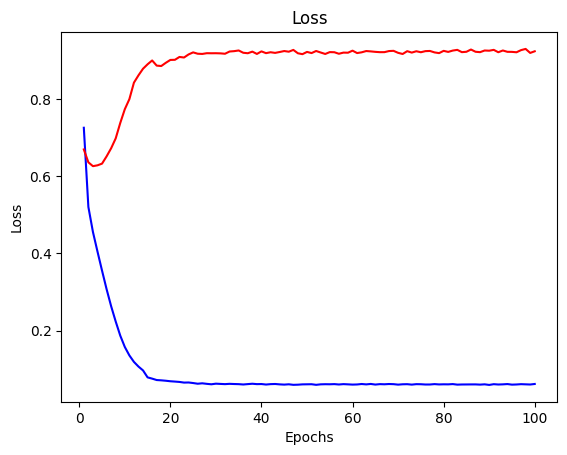

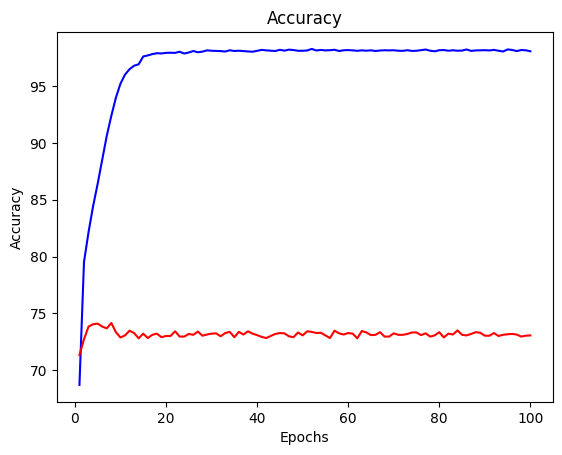

In [12]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Damage_Severity_Classification_ResNet18_pretrained Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


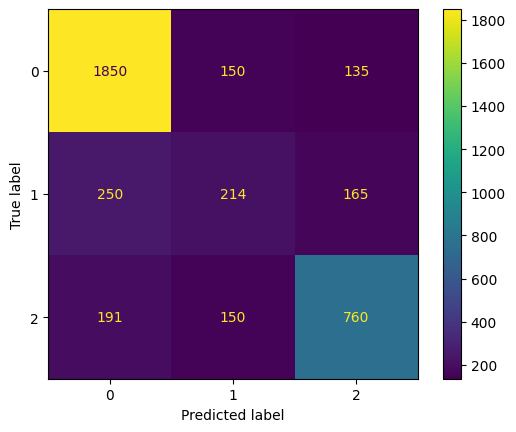

In [13]:
# "severe": 2, "mild": 1, "little_or_none": 0
print(task + '_ResNet18_pretrained Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet101_pretrained

In [7]:
model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [8]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [9]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet101_pretrained_v2.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [10]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.7976 - accuracy: 67.80% - val_loss: 0.7539 - val_accuracy: 69.37% - time: 150.19s
Epoch 2/100 - loss: 0.5535 - accuracy: 77.76% - val_loss: 0.6404 - val_accuracy: 72.94% - time: 149.88s
Epoch 3/100 - loss: 0.4488 - accuracy: 81.68% - val_loss: 0.6122 - val_accuracy: 74.23% - time: 150.03s
Epoch 4/100 - loss: 0.3691 - accuracy: 84.69% - val_loss: 0.6195 - val_accuracy: 74.57% - time: 149.87s
Epoch 5/100 - loss: 0.2992 - accuracy: 87.96% - val_loss: 0.6473 - val_accuracy: 74.57% - time: 149.97s
Epoch 6/100 - loss: 0.2328 - accuracy: 91.20% - val_loss: 0.6846 - val_accuracy: 75.32% - time: 150.24s
Epoch 7/100 - loss: 0.1770 - accuracy: 93.81% - val_loss: 0.7641 - val_accuracy: 74.83% - time: 149.91s
Epoch 8/100 - loss: 0.1337 - accuracy: 95.38% - val_loss: 0.7948 - val_accuracy: 74.70% - time: 150.27s
Epoch 9/100 - loss: 0.1067 - accuracy: 96.31% - val_loss: 0.8225 - val_accuracy: 74.36% - time: 150.31s
Epoch 10/100 - loss: 0.0883 - accuracy: 96.87% - val_loss: 0.871

Epoch 80/100 - loss: 0.0318 - accuracy: 98.66% - val_loss: 1.0202 - val_accuracy: 74.15% - time: 149.93s
Epoch 81/100 - loss: 0.0316 - accuracy: 98.69% - val_loss: 1.0169 - val_accuracy: 74.46% - time: 150.22s
Epoch 82/100 - loss: 0.0319 - accuracy: 98.69% - val_loss: 1.0273 - val_accuracy: 73.97% - time: 149.89s
Epoch 83/100 - loss: 0.0318 - accuracy: 98.74% - val_loss: 1.0297 - val_accuracy: 74.36% - time: 150.13s
Epoch 84/100 - loss: 0.0328 - accuracy: 98.66% - val_loss: 1.0189 - val_accuracy: 74.41% - time: 150.01s
Epoch 85/100 - loss: 0.0341 - accuracy: 98.64% - val_loss: 1.0335 - val_accuracy: 74.85% - time: 149.72s
Epoch 86/100 - loss: 0.0318 - accuracy: 98.72% - val_loss: 1.0279 - val_accuracy: 74.41% - time: 149.84s
Epoch 87/100 - loss: 0.0317 - accuracy: 98.69% - val_loss: 1.0294 - val_accuracy: 73.92% - time: 150.00s
Epoch 88/100 - loss: 0.0318 - accuracy: 98.64% - val_loss: 1.0258 - val_accuracy: 74.41% - time: 150.25s
Epoch 89/100 - loss: 0.0322 - accuracy: 98.64% - val_lo

In [11]:
print(task + '_ResNet101_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet101_pretrained Classification Report:')
print(cr)

Damage_Severity_Classification_ResNet101_pretrained Performance:
Accuracy : 75.96%
F1-Score : 74.31%
Damage_Severity_Classification_ResNet101_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      2135
           1       0.42      0.40      0.41       629
           2       0.71      0.73      0.72      1101

    accuracy                           0.74      3865
   macro avg       0.66      0.66      0.66      3865
weighted avg       0.74      0.74      0.74      3865



## Visualize Results & Confusion Matrix

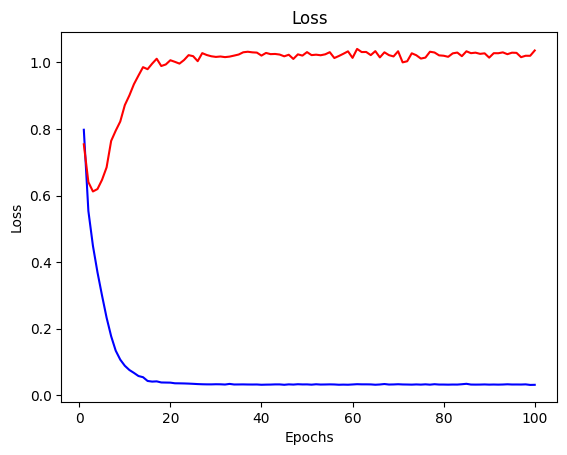

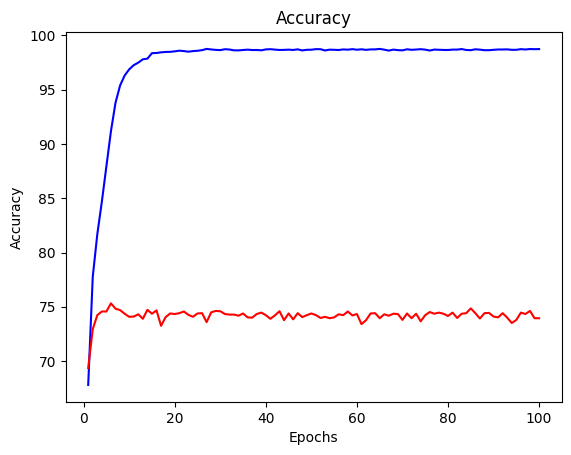

In [12]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Damage_Severity_Classification_ResNet101_pretrained Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


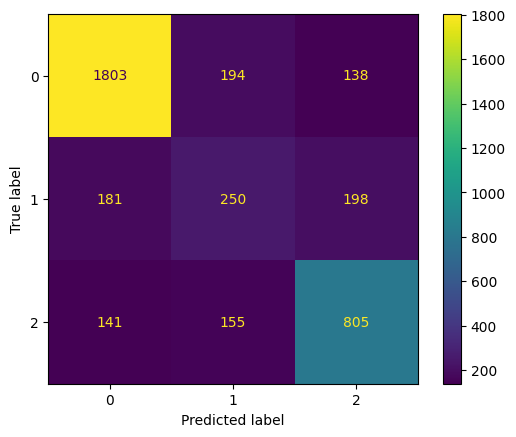

In [13]:
# "severe": 2, "mild": 1, "little_or_none": 0
print(task + '_ResNet101_pretrained Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# DenseNet121_pretrained

In [14]:
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/u9562361/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

## Train

In [15]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [16]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_DenseNet121_pretrained_v2.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [17]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.7130 - accuracy: 71.72% - val_loss: 0.6837 - val_accuracy: 70.97% - time: 106.55s
Epoch 2/100 - loss: 0.5439 - accuracy: 78.69% - val_loss: 0.6276 - val_accuracy: 73.69% - time: 106.27s
Epoch 3/100 - loss: 0.4838 - accuracy: 80.91% - val_loss: 0.6014 - val_accuracy: 74.85% - time: 106.39s
Epoch 4/100 - loss: 0.4356 - accuracy: 82.92% - val_loss: 0.5899 - val_accuracy: 74.85% - time: 106.35s
Epoch 5/100 - loss: 0.3925 - accuracy: 84.85% - val_loss: 0.5857 - val_accuracy: 75.08% - time: 106.29s
Epoch 6/100 - loss: 0.3496 - accuracy: 86.56% - val_loss: 0.5887 - val_accuracy: 75.45% - time: 106.40s
Epoch 7/100 - loss: 0.3065 - accuracy: 88.47% - val_loss: 0.6009 - val_accuracy: 74.93% - time: 106.41s
Epoch 8/100 - loss: 0.2662 - accuracy: 90.46% - val_loss: 0.6209 - val_accuracy: 74.57% - time: 106.35s
Epoch 9/100 - loss: 0.2262 - accuracy: 92.33% - val_loss: 0.6575 - val_accuracy: 74.31% - time: 106.41s
Epoch 10/100 - loss: 0.1902 - accuracy: 93.88% - val_loss: 0.700

Epoch 80/100 - loss: 0.0499 - accuracy: 98.50% - val_loss: 0.9658 - val_accuracy: 72.34% - time: 106.49s
Epoch 81/100 - loss: 0.0518 - accuracy: 98.43% - val_loss: 0.9774 - val_accuracy: 72.37% - time: 106.29s
Epoch 82/100 - loss: 0.0521 - accuracy: 98.43% - val_loss: 0.9636 - val_accuracy: 72.39% - time: 106.43s
Epoch 83/100 - loss: 0.0508 - accuracy: 98.52% - val_loss: 0.9708 - val_accuracy: 72.57% - time: 106.34s
Epoch 84/100 - loss: 0.0494 - accuracy: 98.47% - val_loss: 0.9694 - val_accuracy: 72.26% - time: 106.78s
Epoch 85/100 - loss: 0.0505 - accuracy: 98.43% - val_loss: 0.9634 - val_accuracy: 72.55% - time: 106.39s
Epoch 86/100 - loss: 0.0510 - accuracy: 98.46% - val_loss: 0.9638 - val_accuracy: 72.45% - time: 106.43s
Epoch 87/100 - loss: 0.0517 - accuracy: 98.38% - val_loss: 0.9664 - val_accuracy: 72.68% - time: 106.53s
Epoch 88/100 - loss: 0.0506 - accuracy: 98.49% - val_loss: 0.9671 - val_accuracy: 72.47% - time: 106.40s
Epoch 89/100 - loss: 0.0506 - accuracy: 98.46% - val_lo

In [18]:
print(task + '_DenseNet121_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_DenseNet121_pretrained Classification Report:')
print(cr)

Damage_Severity_Classification_DenseNet121_pretrained Performance:
Accuracy : 76.08%
F1-Score : 74.35%
Damage_Severity_Classification_DenseNet121_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      2135
           1       0.38      0.40      0.39       629
           2       0.73      0.68      0.70      1101

    accuracy                           0.72      3865
   macro avg       0.65      0.64      0.64      3865
weighted avg       0.73      0.72      0.73      3865



## Visualize Results & Confusion Matrix

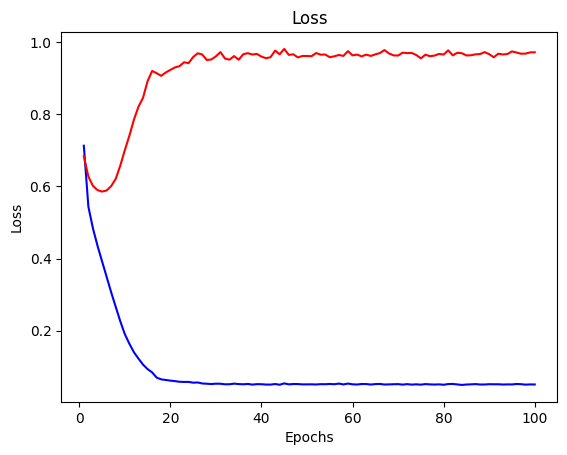

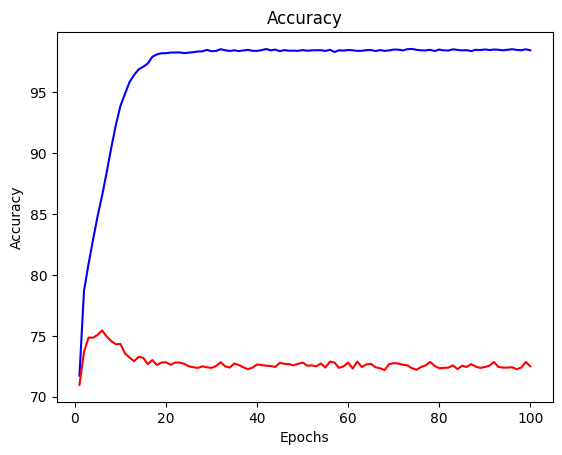

In [19]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Damage_Severity_Classification_DenseNet121_pretrained Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


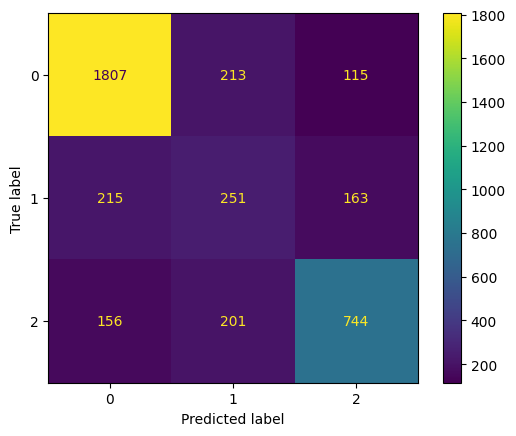

In [20]:
# "severe": 2, "mild": 1, "little_or_none": 0
print(task + '_DenseNet121_pretrained Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()